## Imports

In [1]:
import scipy.io

import os
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.exceptions import NotFittedError

%matplotlib inline
%pylab inline

plt.style.use('seaborn')
pylab.rcParams['figure.figsize'] = (15, 9)

Populating the interactive namespace from numpy and matplotlib


## Load Dataset

In [2]:
dataset = scipy.io.loadmat(os.path.join('data', 'anomalyData.mat'))

X = dataset['X']
np.random.shuffle(X)

x_test, y_test = dataset['Xval'], dataset['yval']

X.shape, x_test.shape, y_test.shape

((307, 2), (307, 2), (307, 1))

## Visualize train data

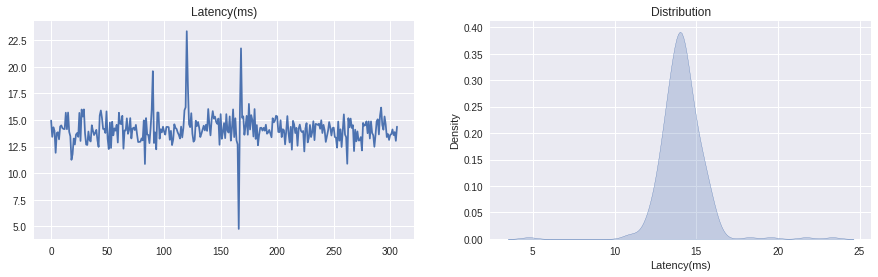

In [3]:
fig = plt.figure(figsize=(15, 4))

ax1 = fig.add_subplot(121)
ax1.plot(X[:, 0])
ax1.set_title('Latency(ms)')

ax2 = fig.add_subplot(122)
sns.kdeplot(x=X[:, 0], fill=True, ax=ax2)
ax2.set_xlabel('Latency(ms)')
ax2.set_title('Distribution')

plt.show()

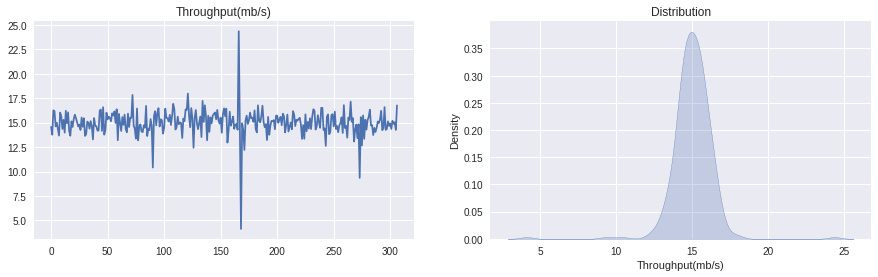

In [4]:
fig = plt.figure(figsize=(15, 4))

ax1 = fig.add_subplot(121)
ax1.plot(X[:, 1])
ax1.set_title('Throughput(mb/s)')

ax2 = fig.add_subplot(122)
sns.kdeplot(x=X[:, 1], fill=True, ax=ax2)
ax2.set_xlabel('Throughput(mb/s)')
ax2.set_title('Distribution')

plt.show()

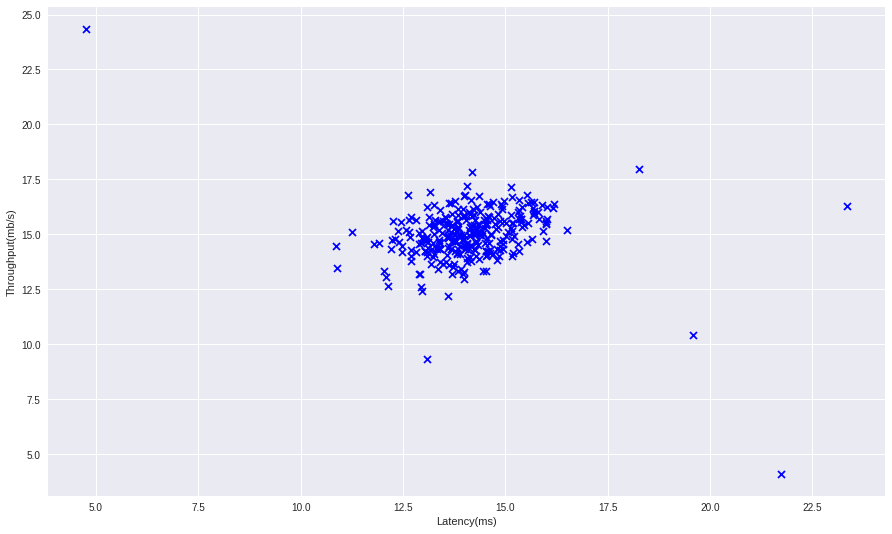

In [5]:
plt.scatter(X[:, 0], X[:, 1], marker='x', c='b')
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

## Visualize test data

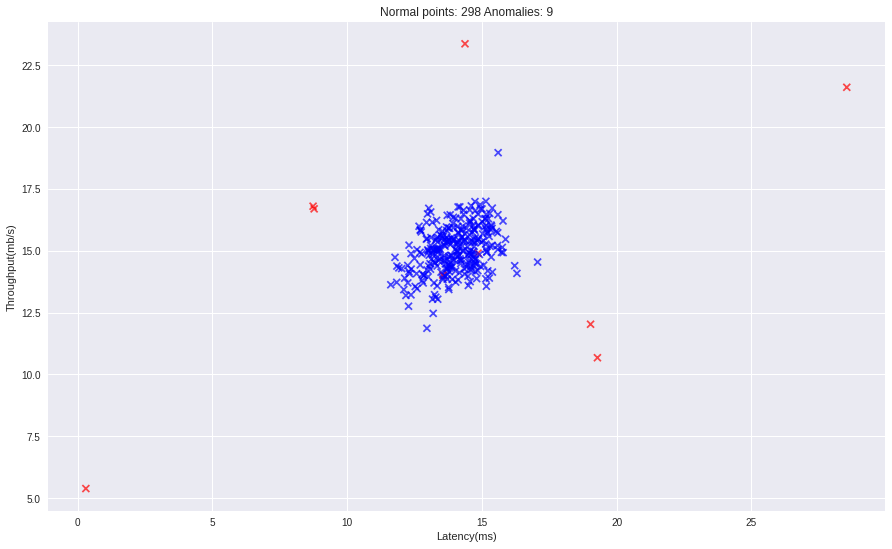

In [6]:
pc, ac = np.bincount(y_test.reshape(-1,))

plt.scatter(x_test[:, 0], x_test[:, 1], marker='x', c=list(map(lambda x: 'b' if x == 0 else 'r', y_test)), alpha=0.7)
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.title(f'Normal points: {pc} Anomalies: {ac}')
plt.show()

## Multivariate Model

In [7]:
class MultivariateGaussian:
    
    def __init__(self):
        self.mean = None
        self.cov = None
        self.epsilon = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.cov = np.cov(X.T)
        
    def save(self):
        
        if self.mean is None or self.cov is None:
            raise NotFittedError('Call the fit method first.')
            
        if self.epsilon is None:
            raise NotFittedError('Call the get_epsilon method first.')
        
        np.savetxt(os.path.join('data', 'mean.csv'), self.mean, delimiter=',')
        np.savetxt(os.path.join('data', 'cov.csv'), self.cov, delimiter=',')
        np.savetxt(os.path.join('data', 'epsilon.csv'), [self.epsilon], delimiter=',')
    
    def get_probability(self, x, mean=None, cov_matrix=None):
        mean = self.mean if mean is None else mean
        cov_matrix = self.cov if cov_matrix is None else cov_matrix
        
        if type(x) == int:
            x = np.array([x]).reshape(-1, 1)

        m, n = x.shape

        if m == 1 or n == 1:
            cov_matrix = np.diag(cov_matrix[0, :])

        x_mu = x - mean

        power = (1 / 2) * np.sum(np.dot(x_mu, np.linalg.pinv(cov_matrix)) * x_mu, axis=1)
        prob = (1 / ((2 * np.pi)**(n / 2) * np.linalg.det(cov_matrix)**(0.5))) * np.exp(-power)

        return prob
    
    def predict(self, X, epsilon=None, mean=None, cov_matrix=None):
        prob = self.get_probability(X, mean, cov_matrix)
        return np.array(list(map(lambda x: 1 if x < epsilon else 0, prob)))
    
    def extract_anomalies(self, x, probability, epsilon):
        anomaly_indices = np.where(probability < epsilon)
        anomalies = x[anomaly_indices]

        return anomalies
    
    def get_epsilon(self, y_true, y_pred):
    
        f1 = 0
        best_f1 = 0
        best_epsilon = 0

        stepsize = (np.max(y_pred) - np.min(y_pred)) / 1000

        epsilon_vector = np.arange(np.min(y_pred), np.max(y_pred), stepsize)
        n = len(epsilon_vector)

        for i in range(n):
            epsilon = epsilon_vector[i]
            pred = list(map(lambda x: 1 if x else 0, y_pred < epsilon))

            f1 = f1_score(y_true, pred)

            if f1 > best_f1:
                best_f1 = f1
                best_epsilon = epsilon
    
        self.epsilon = best_epsilon        
        return best_epsilon
    
    def load(self, path_to_mean=None, path_to_cov=None, path_to_epsilon=None):
        
        mean = os.path.join('data', 'mean.csv') if path_to_mean is None else path_to_mean
        cov = os.path.join('data', 'cov.csv') if path_to_cov is None else path_to_cov
        epsilon = os.path.join('data', 'epsilon.csv') if path_to_epsilon is None else path_to_epsilon
        
        self.mean = np.loadtxt(mean, delimiter=',')
        self.cov = np.loadtxt(cov, delimiter=',')
        self.epsilon = np.loadtxt(epsilon, delimiter=',')

## Train and Test

In [8]:
model = MultivariateGaussian()

model.fit(X)
epsilon = model.get_epsilon(y_test, model.get_probability(x_test))

model.save()  # optional, saves the model
model.load()  # optional, loads the saved model

pred = model.predict(X, epsilon)
y_pred = model.predict(x_test, epsilon)

print('Mean:', model.mean)
print('Covariance Matrix:\n', model.cov)
print('Epsilon:', model.epsilon)
print('Anomalies in train data:', np.unique(pred, return_counts=True)[1][1])
print('Anomalies in test data:', np.unique(y_pred, return_counts=True)[1][1])

Mean: [14.11222578 14.99771051]
Covariance Matrix:
 [[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]
Epsilon: 9.036240676156382e-05
Anomalies in train data: 6
Anomalies in test data: 7


## Visualizing decision boundary

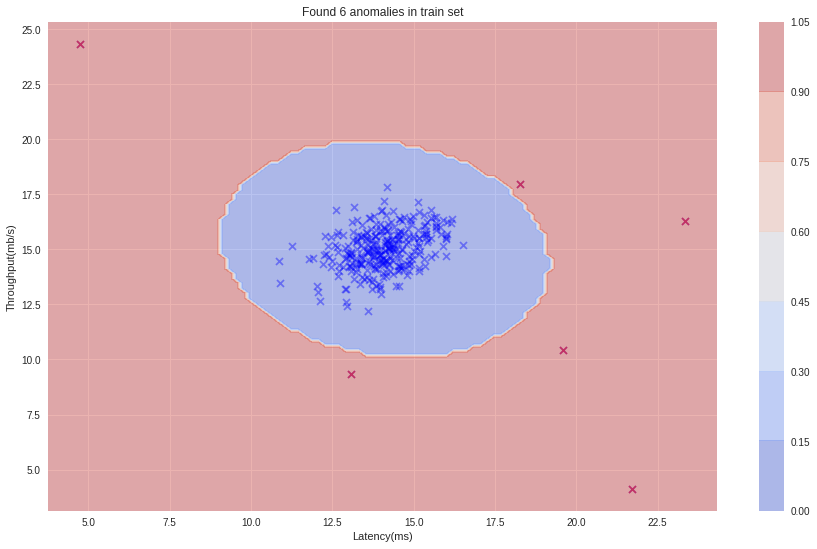

In [9]:
xlist = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
ylist = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
XPlot, YPlot = np.meshgrid(xlist, ylist)
pos = np.c_[XPlot.ravel(), YPlot.ravel()]

anomalies = model.extract_anomalies(X, model.get_probability(X), epsilon)

Z = model.predict(pos, epsilon)
Z = Z.reshape(XPlot.shape)

plt.contourf(XPlot, YPlot, Z, alpha=0.4, cmap='coolwarm')
plt.colorbar()

plt.scatter(X[:, 0], X[:, 1], marker="x", alpha=0.4, color='b')
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.title(f'Found {anomalies.shape[0]} anomalies in train set')
plt.scatter(anomalies[:, 0], anomalies[:, 1], marker='x', color='r', alpha=0.5)

plt.show()

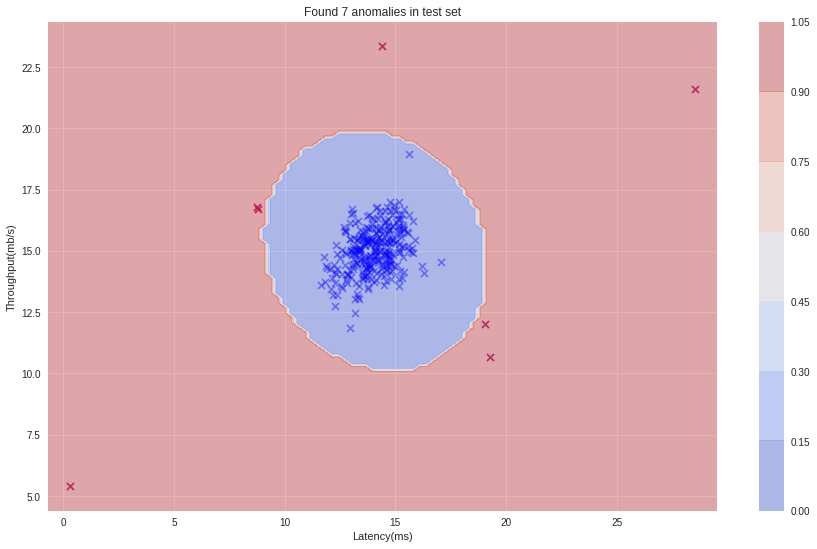

In [10]:
xlist = np.linspace(x_test[:, 0].min() - 1, x_test[:, 0].max() + 1, 100)
ylist = np.linspace(x_test[:, 1].min() - 1, x_test[:, 1].max() + 1, 100)
XPlot, YPlot = np.meshgrid(xlist, ylist)
pos = np.c_[XPlot.ravel(), YPlot.ravel()]

anomalies = model.extract_anomalies(x_test, model.get_probability(x_test), epsilon)

Z = model.predict(pos, epsilon)
Z = Z.reshape(XPlot.shape)

plt.contourf(XPlot, YPlot, Z, alpha=0.4, cmap='coolwarm')
plt.colorbar()

plt.scatter(x_test[:, 0], x_test[:, 1], marker="x", alpha=0.4, c='b')
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.title(f'Found {anomalies.shape[0]} anomalies in test set')
plt.scatter(anomalies[:, 0], anomalies[:, 1], marker='x', color='r', alpha=0.5)

plt.show()